In [1]:
import random

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns

In [4]:
class Card():
    def __init__(self, value, provisions = None, thins = False):
        self.value = value
        if provisions == None:
            self.provisions = value
        else:
            self.provisions = provisions
        self.thins = thins

In [5]:
def drawHand(deck, cardsToDraw):
    deck = deck[:]
    hand = []
    for card in range(cardsToDraw):
        hand.append(deck.pop())
    return (hand, deck)

def drawMore(trialDeck, cardsToDraw, hand):
    for card in range(cardsToDraw):
        hand.append(trialDeck.pop())
        
def thin(trialDeck):
    for card in trialDeck[::]:
        if card.thins:
            trialDeck.remove(card)

In [14]:
def initialMulligans(trialDeck, hand, mulls, mulliganCount):
    mullTaken = False
    for i in range(mulliganCount):
        for card in hand[::]:
            if card.thins == True and len(mulls) < mulliganCount and len(trialDeck) != 0:
                mullTaken=True
                hand.remove(card)
                mulls.append(card)
                hand.append(trialDeck.pop())
                
    if mullTaken == True and len(mulls) < mulliganCount:
        initialMulligans(trialDeck, hand, mulls, mulliganCount)
        
def finalMulligans(trialDeck, hand, mulls, mulliganCount):
    while mulliganCount > len(mulls) and len(trialDeck) != 0:
        if (float(sum([x.value for x in trialDeck]) / len(trialDeck))) > min(hand, key=lambda x: x.value).value:
            mulled = min(hand, key=lambda x: x.value)
            mulls.append(mulled)
            hand.remove(mulled)
            
            hand.append(trialDeck.pop())
        else:
            break
def runMulliganTrial(deck, mulliganCount):
    mulls = []
    thinValue = sum([x.value for x in deck if x.thins == True])
    random.shuffle(deck)
    hand, trialDeck = drawHand(deck, 10)
    
    #just so I stop referencing deck when I mean to reference trialDeck. This caused like 3 different bugs.
    deck = None
    
    initialMulligans(trialDeck, hand, mulls, mulliganCount)
    thin(trialDeck)
    drawMore(trialDeck, 6, hand)
    handStrengthBefore = sum([x.value for x in hand])
    finalMulligans(trialDeck, hand, mulls, mulliganCount)
                

            
    deckStrength = sum([x.value for x in trialDeck]) + sum([x.value for x in mulls])
    handStrengthAfter = sum([x.value for x in hand])
    
    #any thinning cards leftover shouldn't be double counted, and we already counted their value above
    thinValue -= sum(x.value for x in hand if x.thins == True) 
    handStrengthAfter += thinValue
    return (handStrengthBefore, handStrengthAfter, deckStrength)

In [15]:
def gatherSamples(deck, mulliganCount, sampleSize):
    differences = []
    afters = []
    leftovers = []
    for i in range(sampleSize):
        before, after, deckStrength = runMulliganTrial(deck, mulliganCount)
        afters.append(after)
        differences.append(after - before)
        leftovers.append(deckStrength)
    return (differences, afters, leftovers)

In [16]:
def runExperiment(deck, numMulls, deckName, graph = False):
    differences, afters, leftovers = gatherSamples(deck, numMulls, 10000)
    
    avgGain = sum(differences) / len(differences)
    if numMulls != 0:
        avgGainPerMull = avgGain / numMulls
    else:
        avgGainPerMull = 0
    avgStrength = sum(afters) / len(afters)
    avgLeftovers = sum(leftovers) / len(leftovers)
    print(f"{numMulls} mulligans, {deckName}")
    print(f"average gain: {avgGain}")
    print(f"average gain per mulligan: {avgGainPerMull}")
    print(f"average value after mulligans:{avgStrength}")
    if graph:
        sns.countplot([int(x / 3) * 3 for x in afters])
    print(f"average value left in deck: {avgLeftovers}")
    print("")

## That's it for the baseline code, the following is going to be the various experiments.

#### Reading Decks

The part "([Card(4)] * 5)" should be read as, "add 5 cards to the deck that cost 4, and are worth 4 points." Similarly, "([Card(5)] * 10)" is "add 10 cards to the deck that cost 5 and are worth 5 points." For the first example, this is all you need to know. However, there are a few more parameters that can be added to the Card constructor. "Card(4, 5)" would add a card to the deck that costs 5 provisions, but is only worth 4 points. 

There is one last parameter, and it simulates cards like Roach. "Card(4, 10, True)" adds a card that is worth 4, costs 10, but comes out of your deck for free in round 1. The "True" is the thinning parameter. If a card with thinning is in your deck after mulligans, it is removed from the deck and the points it would provide are added to your total. 

#### How this simulator works

For each trial, 10 cards are initally drawn. An initial mulligan phase is taken to remove any cards that have thinning enabled, but no further mulligans are wasted. After this mulligan, all cards with thinning are removed from the deck, and their points are added to the total points played for the game. Finally, 6 more cards are drawn to simulate the round 2 and 3 draws, and finally mulligans are taken using a full 16 card hand, mulliganning the cheapest cards in hand as long as the average point value of a card in deck is worth more than the cheapest card in the hand. 

the "Average value after mulligan" result corresponds to the total number of points you have access to throughout the entire game. It's worth noting that this doesn't provide any kind of discount to cards dumped in earlier rounds where points don't matter as much, so take these numbers with a grain of salt, they're probably higher than you should expect unless you're doing something weird. In many cases these decks will go all game without "playing" a single 4 provision card. Imagine these numbers as going straight to round 3 with 16 cards in hand, and taking all your available mulligans there. 

The graph after the results shows the frequency distribution over the 10,000 trial runs of hands with a given point value, rounded to a multiple of 3 to limit the number of categories and make the graph readable. 

## The First Experiment

The first deck we're going to look at is the following. 

([Card(4)] * 5) + ([Card(5)] * 10) + ([Card(9)] * 5) + ([Card(10)] * 5)

a 25 card deck, with 165 total provisions as expected, and a simple distribution of values. 

First, we're going to look to see how the number of mulligans changes the expected point total. In this next cell, we're going to run a set of trials with 10,000 samples where the deck has 4 total mulligans. Then in the following cell, we have a similar set of trials, but this time with only a single mulligan.

Total Provisions: 165
Deck Size: 25

4 mulligans, balanced deck
average gain: 10.0094
average gain per mulligan: 2.50235
average value after mulligans:115.6445
average value left in deck: 49.3555



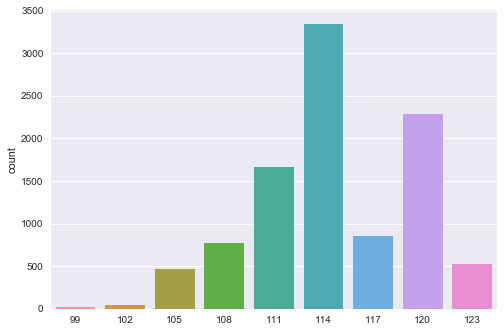

In [59]:
deck = ([Card(4)] * 5) + ([Card(5)] * 10) + ([Card(9)] * 5) + ([Card(10)] * 5)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))

runExperiment(deck, 4, "balanced deck", graph = True)

Total Provisions: 165
Deck Size: 25

1 mulligans, balanced deck
average gain: 2.5849
average gain per mulligan: 2.5849
average value after mulligans:108.2271
average value left in deck: 56.7729



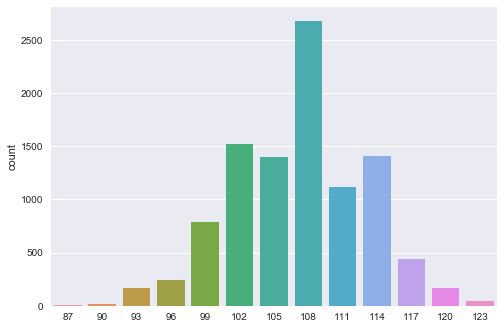

In [60]:
deck = ([Card(4)] * 5) + ([Card(5)] * 10) + ([Card(10)] * 5) + ([Card(9)] * 5)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))

runExperiment(deck, 1, "balanced deck", graph=True)

### Interpretation

After 4 mulligans, the deck typically had access to 115 points, with a range of between ~93 - ~123, skewed towards the topend. The 4 mulligans ended up adding around 10 points to this total, making a mulligan worth about 2.5 points in that deck. 

In the deck with only a single mulligan, there was only an average of 108 total points, with a range between ~84 - ~123 with a distribution a bit more centralized. The mulligan on average added about 2.6 points to the hand, making this mulligan worth 2.6.

This 2.6 number doesn't come out of nowhere. 2.6 is the difference between the minimum value for a card, 4, and the average value of a card in the deck, 165 / 25, or 6.6. Any time you mulligan a 4 while your deck still has a regular distribution in it, you'd expect to draw an average card from the deck, which improves your hand by 2.6 points. The reason why the deck with 4 mulligans gets slightly less value per mulligan, is that you can eventually run out of 4s to mulligan, and when you kick a 5, you're only gaining 1.6 value. Let's look at one simple example to drive this point home.

### Mulligans with min(5)

In this next deck we're going to cut all the 4s and just play 5s. Naturally, we need to make a trade on the topend, so we cut the 10s and turn them into 9s to keep the deck's total the same.

In [48]:
deck = ([Card(5)] * 5) + ([Card(5)] * 10) + ([Card(9)] * 5) + ([Card(9)] * 5)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))

runExperiment(deck, 4, "Mull with min(5)", graph=False)
runExperiment(deck, 1, "Mull with min(5)", graph=False)

Total Provisions: 165
Deck Size: 25

4 mulligans, Mull with min(5)
average gain: 6.4568
average gain per mulligan: 1.6142
average value after mulligans:112.0232
average value left in deck: 52.9768

1 mulligans, Mull with min(5)
average gain: 1.6208
average gain per mulligan: 1.6208
average value after mulligans:107.2116
average value left in deck: 57.7884



And we get the results expected. Rather than 6.6 - 4, we're getting 6.6 - 5 as our average gain. Also, since there are twice as many 5s than there were 4s before, with 4 mulligans we still haven't hit the point of diminishing returns.

### Extreme Decks

In this next set, we're going to look at a deck with 10 6s, and 15 7s, the lowest variance 165 provision deck you can build. Then we'll look at a high variance version, with a mix of 12s and 4s.  

Total Provisions: 165
Deck Size: 25

4 mulligans, low variance
average gain: 2.416
average gain per mulligan: 0.604
average value after mulligans:108.0051
average value left in deck: 56.9949

1 mulligans, low variance
average gain: 0.6033
average gain per mulligan: 0.6033
average value after mulligans:106.1721
average value left in deck: 58.8279



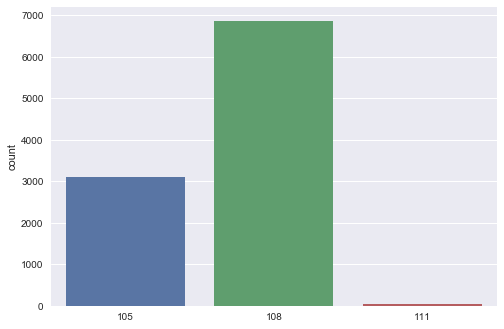

In [54]:
deck = ([Card(6)] * 10) + ([Card(7)] * 15)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))
runExperiment(deck, 4, "low variance", graph=True)
runExperiment(deck, 1, "low variance", graph=False)

Total Provisions: 165
Deck Size: 25

4 mulligans, high variance
average gain: 10.3933
average gain per mulligan: 2.598325
average value after mulligans:116.0179
average value left in deck: 48.9821

1 mulligans, high variance
average gain: 2.6373
average gain per mulligan: 2.6373
average value after mulligans:108.1699
average value left in deck: 56.8301



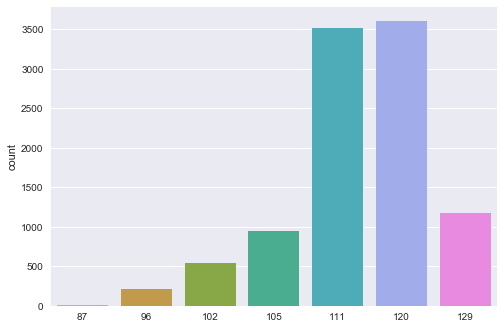

In [58]:
deck = ([Card(4)] * 17) + ([Card(12)] * 7) + ([Card(13)] * 1)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))
runExperiment(deck, 4, "high variance", graph=True)
runExperiment(deck, 1, "high variance", graph=False)

### Results

Mulligans give a pretty huge drawback to having a more balanced deck. With no 4s to mulligan, all your mulligan value is essentially wasted. You lose the ability to even have high value cards in your hand, and most of the time you will be able to mulligan your 4s to improve the quality of your hand. Playing a balanced deck with no thinning to take advantage of mulligans is literally throwing points away, even with only a single mulligan.

There is little difference between the "balanced" deck we used initially, and the high variance deck made up of only 4s and 12/13s. The range is a bit more wide, but the average is identical.

### Roach

Okay, so all of the previous examples have been with no thinning at all, just draws and mulligans. What do these numbers look like if we add the simplest self-thinning card to the deck? The way this is going to work is explained more in the "how this simulator works" section above, so for now let's just look at the numbers. We're going to have a deck with a similar distribution as the first deck we looked at, but trading one of the 10s for a Roach.

Total Provisions: 165
Deck Size: 25

4 mulligans, balanced deck + Roach
average gain: 12.7014
average gain per mulligan: 3.17535
average value after mulligans:116.0055
average value left in deck: 44.5985



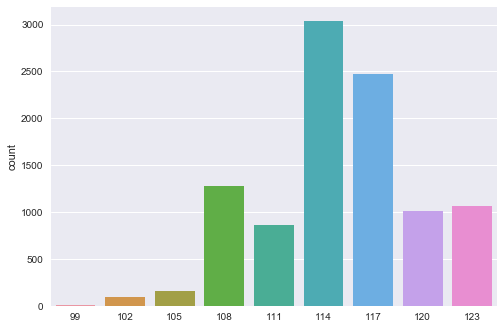

In [61]:
deck = ([Card(4)] * 5) + ([Card(5)] * 10) + ([Card(10)] * 4) + ([Card(9)] * 5) + ([Card(4, 10, True)] * 1)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))

runExperiment(deck, 4, "balanced deck + Roach", graph = True)

Total Provisions: 165
Deck Size: 25

1 mulligans, balanced deck + Roach
average gain: 5.441
average gain per mulligan: 5.441
average value after mulligans:108.9214
average value left in deck: 51.687



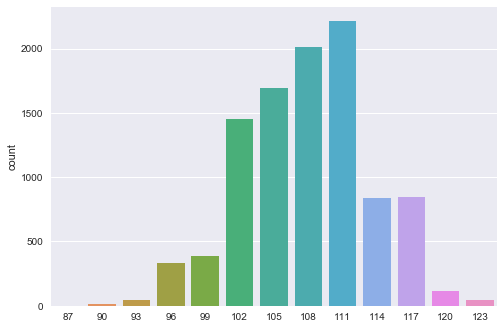

In [62]:
deck = ([Card(4)] * 5) + ([Card(5)] * 10) + ([Card(10)] * 4) + ([Card(9)] * 5) + ([Card(4, 10, True)] * 1)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))

runExperiment(deck, 1, "balanced deck + Roach", graph = True)

### Interpretation

As a reminder, these were the numbers without the Roach:

4 mulligans, balanced deck  
average gain: 10.0094  
average gain per mulligan: 2.50235  
**average value after mulligans: 115.6445**  
average value left in deck: 49.3555  


1 mulligans, balanced deck  
average gain: 2.5849  
average gain per mulligan: 2.5849  
**average value after mulligans: 108.2271**  
average value left in deck: 56.7729  

The averages with Roach being 108.9, and 116, this prices roach at around 10.4-10.7 provisions, depending on how many mulligans you have. Somewhat counterintuitively, the more mulligans you have access to, the less valuable Roach becomes. This is because you need to cut a 10 point card from your deck to find room for Roach, which means all of the times you mulligan a 4 later on, you're less likely to hit a powerful card, because there are less of them, and this outweighs the cost of needing to take your only mulligan round 1 on Roach if it's in your hand.

### Extreme Decks Revisited

Let's revisit our extreme decks from before though, does having Roach make the deck that doesn't gain much from mulligans more attractive?

Total Provisions: 165
Deck Size: 25

4 mulligans, low variance
average gain: 5.6447
average gain per mulligan: 1.411175
average value after mulligans:108.9841
average value left in deck: 51.6043

1 mulligans, low variance
average gain: 4.2738
average gain per mulligan: 4.2738
average value after mulligans:107.5946
average value left in deck: 53.0134



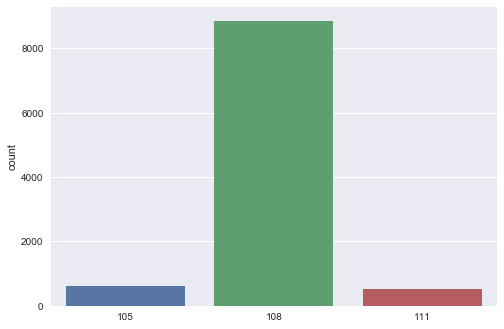

In [67]:
deck = ([Card(6)] * 13) + ([Card(7)] * 11)  + ([Card(4, 10, True)] * 1)
print(f"Total Provisions: %s" % sum([x.provisions for x in deck]))
print(f"Deck Size: %s\n" % len(deck))
runExperiment(deck, 4, "low variance", graph=True)
runExperiment(deck, 1, "low variance", graph=False)

Well, slightly. If you recall from before, these were the numbers we got earlier:
4 mulligans, low variance  
average gain: 2.416  
average gain per mulligan: 0.604  
**average value after mulligans:108.0051**  
average value left in deck: 56.9949  

1 mulligans, low variance  
average gain: 0.6033  
average gain per mulligan: 0.6033  
**average value after mulligans:106.1721**  
average value left in deck: 58.8279  

This deck gets a bit more value out of roach for the first mulligan than the regular decks, getting about 11.4 value